In [11]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import sklearn
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import gaussian_process
from sklearn import ensemble
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
# from mpl_toolkits.mplot3d import axes3d
# cm = plt.cm.get_cmap('RdYlBu')

# Load data

In [12]:
data_file = 'platypus_data.csv'
chr21_df = pd.read_csv(data_file)
chr21_df

,chr,maxVariants,minPosterior,minReads,time,precision,recall,f1
0,21,10.0,5.0,2.0,26.078833,0.589095,0.809952,0.682091
1,21,12.0,5.0,2.0,25.402267,0.588659,0.809952,0.681798
2,21,14.0,5.0,2.0,24.356217,0.589275,0.809809,0.682161
3,21,16.0,5.0,2.0,23.834533,0.589676,0.809952,0.682480
4,21,18.0,5.0,2.0,23.320267,0.590234,0.809809,0.682803
5,21,2.0,5.0,2.0,3.882733,0.589351,0.808954,0.681908
6,21,20.0,5.0,2.0,22.653017,0.590594,0.809809,0.683044
7,21,4.0,5.0,2.0,9.383150,0.585553,0.810664,0.679961
8,21,6.0,5.0,2.0,23.389450,0.585570,0.809952,0.679722
9,21,8.0,5.0,2.0,26.649967,0.587705,0.810094,0.681209


# default values

In [21]:
defaults = {'chr': 21, 'maxVariants': 8, 'minPosterior': 5, 'minReads': 2}
outputs = {'time': [], 'precision': [], 'recall': [], 'f1': []}

# define functions for evaluation

In [13]:
def evaluate(input_data, output_data):
    # apply 10-fold cross validation to evaluate different models
    # input data: features to use
    # output_data: the thing to predict
    
    # models
    reg_dic = {'linear regression': linear_model.LinearRegression(), 'linear Ridge': linear_model.Ridge(), 
                   'RANSAC regression': linear_model.RANSACRegressor(), 'Lasso': linear_model.Lasso(), 
               'Gaussian': gaussian_process.GaussianProcessRegressor(), 'AdaBoost': ensemble.AdaBoostRegressor(), 
               'GBR': ensemble.GradientBoostingRegressor(), 'Random Forest': ensemble.RandomForestRegressor()}
    
    # header
    print('{:<20}{:<15}{:<15}{:<15}{:<15}'.format('Model', 'MAE', 'MSE', 'R2', 'Error Rate'))
    
    # get split for cross validation
    cv = KFold(n_splits=10, shuffle=True)
    
    for reg_name, reg in reg_dic.items():
        maes = []
        mses = []
        r2s = []
        err_rate = []
        for train_index, test_index in cv.split(input_data, output_data):
            # split train and test according to cross validation
            X_train, X_test = input_data[train_index], input_data[test_index]
            y_train, y_test = output_data[train_index], output_data[test_index]
            
            # fit
            reg.fit(X_train, y_train)
            
            # test with test data
            y_pred = reg.predict(X_test)
            
            #calculate metrics
            maes.append(metrics.mean_absolute_error(y_test, y_pred))
            mses.append(metrics.mean_squared_error(y_test, y_pred))
            r2s.append(metrics.r2_score(y_test, y_pred))
            err_rate.append(np.mean((y_pred-y_test)/y_test))

        print('{:<20}{:<15.3e}{:<15.3e}{:<15.3e}{:<15.3e}'.format(reg_name, np.mean(maes), np.mean(mses), np.mean(r2s), np.mean(err_rate)))

In [25]:
def evaluate_plot(chr_df, defaults_value, target_name):
    # draw plot
    # chr_df: pandas dataframe, including input data and target data
    # defaults_value: used to split input data and target data, and build data for plot
    # target name: specify which to predict
    
    # get train data and target data
    train_data = chr21_df.to_numpy()[:, :len(defaults_value.keys())]
    target = chr21_df[target_name].to_numpy()
    X_train = train_data
    y_train = target
    
    # models
    reg_dic = {'linear regression': linear_model.LinearRegression(), 'linear Ridge': linear_model.Ridge(), 
               'RANSAC regression': linear_model.RANSACRegressor(),  'Lasso': linear_model.Lasso(), 
                'Gaussian': gaussian_process.GaussianProcessRegressor(), 'AdaBoost': ensemble.AdaBoostRegressor(), 
                'GBR': ensemble.GradientBoostingRegressor(), 'Random Forest': ensemble.RandomForestRegressor()}

    for reg_name, reg in reg_dic.items():
        print('Current model: ' + reg_name)
        
        # train with all data
        reg.fit(X_train, y_train)
    
#         print(chr_df.columns)
        # figures
        fig,axes=plt.subplots(len(defaults_value.keys())-1,1, figsize=(12,4*(len(defaults_value.keys())-1)))
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        count = 0
        for idx, param in enumerate(chr_df.columns):
            # exclude chr feature
            if param not in defaults_value.keys() or param == 'chr':
                count += 1
                continue
            idx -= count
            
            # calculate range of the current parameter to draw curve
            param_range = np.arange(min(chr_df.loc[:, param]), max(chr_df.loc[:, param]), (max(chr_df.loc[:, param])-min(chr_df.loc[:, param]))/500).reshape(-1,1)

            # get all chr number in chr feature
            chr_list = list(set(chr_df.loc[:, 'chr']))
            
            
            for cur_chr in chr_list:
                # define run_data, and fill in blank using default value. use it as input data for predicting plot
                run_data = None
                defaults_value['chr'] = cur_chr
                for par in chr_df.columns:
                    if par not in defaults_value.keys():
                        continue
                    if run_data is None:
                        run_data = np.array([defaults_value[par]]*len(param_range)).reshape(-1,1)
                    else:
                        if par is not param:
                            run_data = np.concatenate((run_data, np.array([defaults_value[par]]*len(param_range)).reshape(-1,1)),axis=1)
                        else:
                            run_data = np.concatenate((run_data, param_range),axis=1)
                
                # get prediction
                y_pred = reg.predict(run_data)
                
                # draw predicting plot
                axes[idx].plot(param_range, y_pred, label='chr{}'.format(cur_chr))
                
                # draw real data with different colors for different chromosome
                real_chr_data = chr_df.copy()
                for p, v in defaults_value.items():
                    if p == param:
                        continue
                    else:
                        real_chr_data = real_chr_data[(chr_df[p] == v)]
                axes[idx].scatter(real_chr_data.loc[:,param], real_chr_data.loc[:,target_name], label='real_chr{}'.format(cur_chr))
            
            # other figs configuration
            fig.suptitle(reg_name, fontsize=20)
            axes[idx].set_ylabel(target_name)
            axes[idx].set_xlabel(param)
            axes[idx].legend()
        plt.show()
            


# run evaluate

In [15]:
train_data = chr21_df.to_numpy()[:, :4]
print(train_data.shape)
time = chr21_df['time'].to_numpy()
print(time.shape)
f1 = chr21_df['f1'].to_numpy()
f1.shape

(120, 4)
(120,)


(120,)

In [26]:
# predict time
evaluate(train_data, time)

Model               MAE            MSE            R2             Error Rate     
linear regression   2.835e+00      2.131e+01      6.647e-01      2.810e+01      
linear Ridge        2.822e+00      1.964e+01      6.527e-01      2.808e+01      
RANSAC regression   2.057e+00      2.479e+01      5.891e-01      3.256e+01      
Lasso               3.770e+00      2.434e+01      6.021e-01      2.645e+01      
Gaussian            1.142e+00      1.218e+01      8.391e-01      2.482e+01      
AdaBoost            1.895e+00      1.519e+01      7.478e-01      3.052e+01      
GBR                 8.782e-01      9.203e+00      8.589e-01      3.182e+01      
Random Forest       1.041e+00      1.015e+01      8.605e-01      3.151e+01      


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
# predict f1 score
evaluate(train_data, f1)

Model               MAE            MSE            R2             Error Rate     
linear regression   3.444e-03      2.587e-05      9.010e-01      8.888e-05      
linear Ridge        3.436e-03      2.597e-05      9.104e-01      9.331e-05      
RANSAC regression   3.265e-03      2.549e-05      9.094e-01      6.951e-04      
Lasso               1.498e-02      3.038e-04      -8.791e-02     6.637e-04      
Gaussian            1.272e-02      2.373e-03      -7.766e+00     -1.870e-02     
AdaBoost            2.525e-03      9.668e-06      9.593e-01      -1.651e-03     
GBR                 5.237e-04      2.380e-06      9.906e-01      -2.813e-04     
Random Forest       1.101e-03      1.094e-05      9.462e-01      2.602e-04      


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Each model has a set of subplots
### In each subplots, only one parameter is changed; others remain default value
### For different color, the chr feature is set for prediction, and true data uses its own chr. 

Current model: linear regression


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index

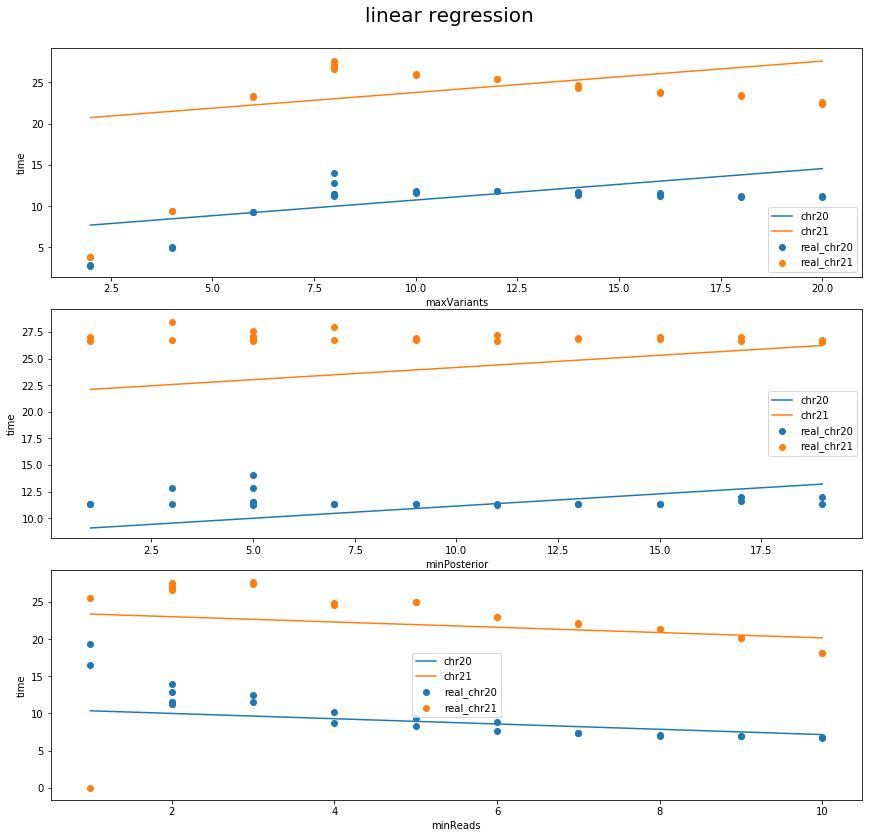

Current model: linear Ridge


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index

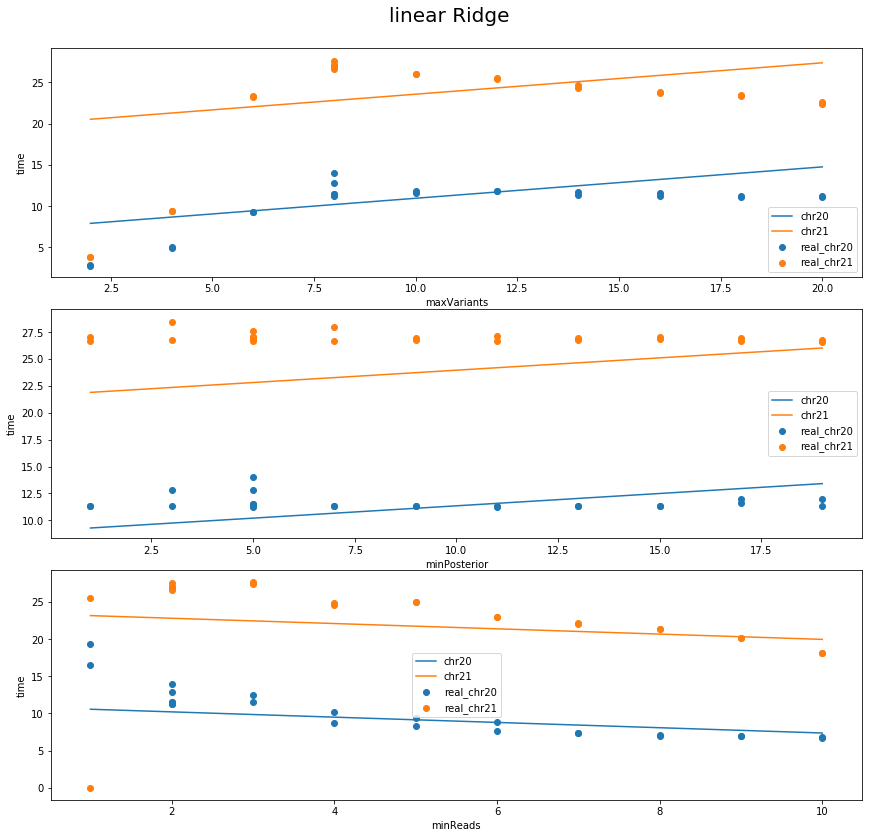

Current model: RANSAC regression


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index

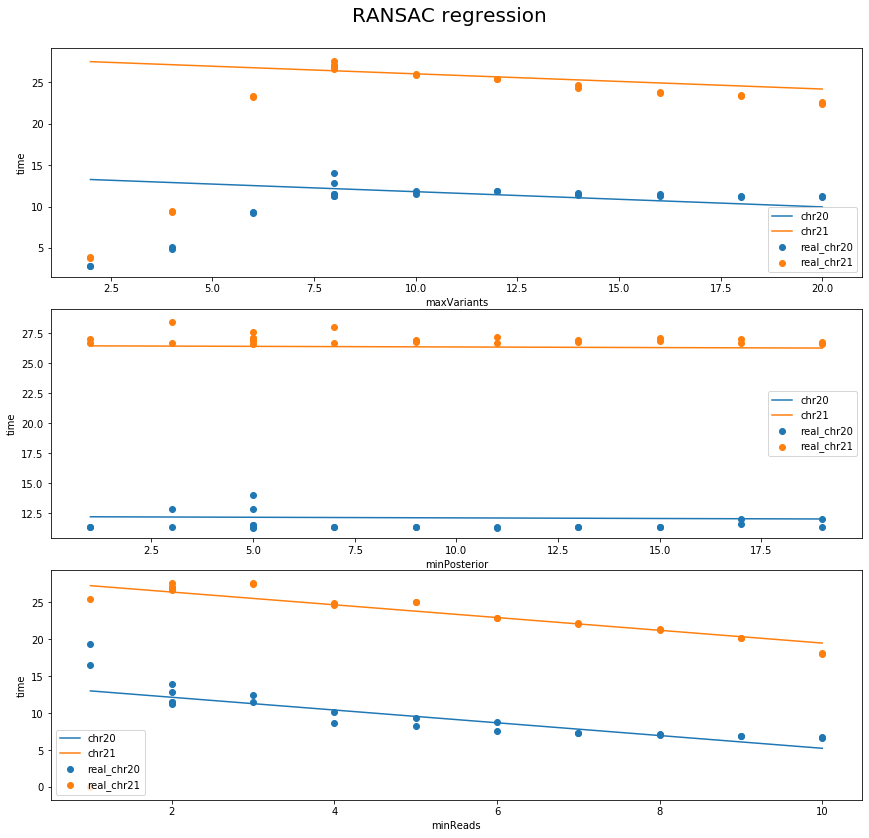

Current model: Lasso


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index

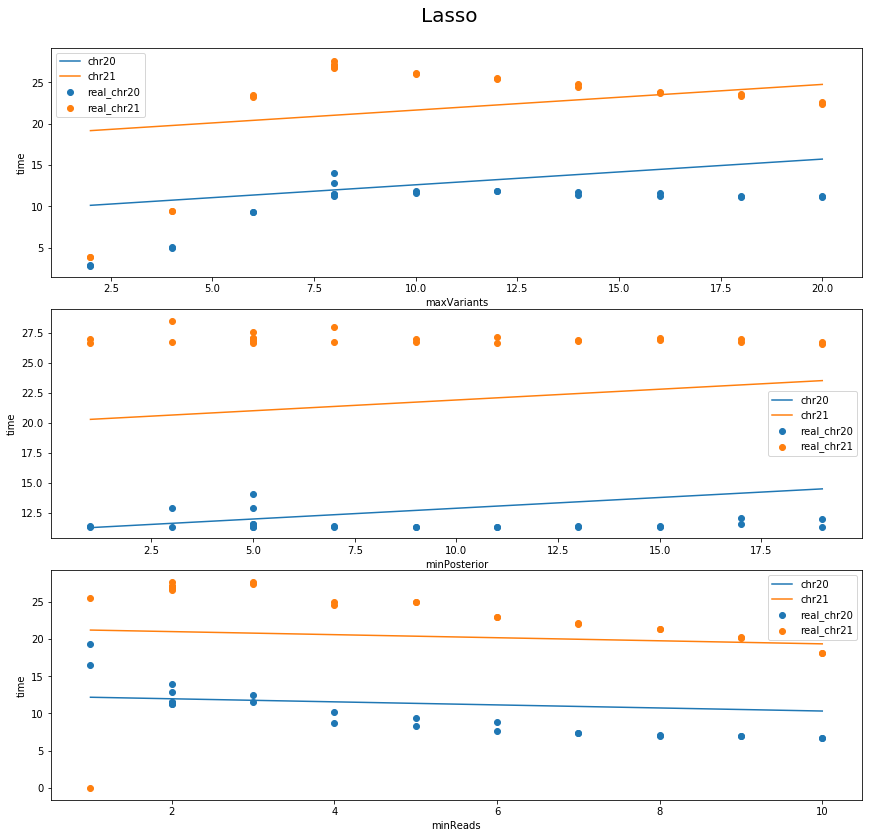

Current model: Gaussian


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index

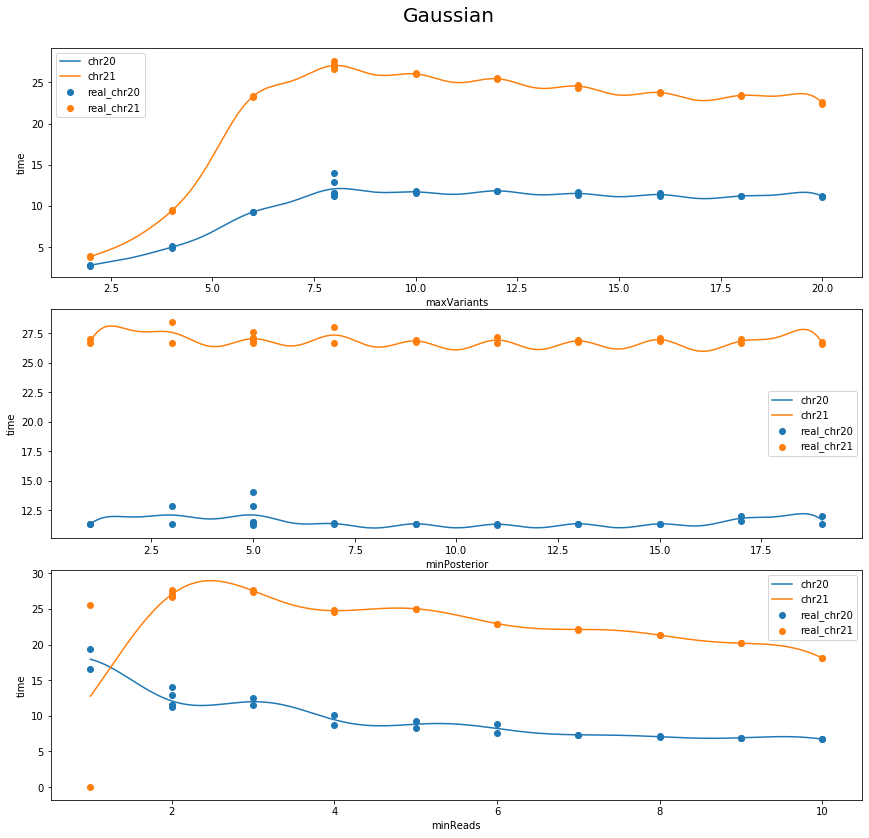

Current model: AdaBoost


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index

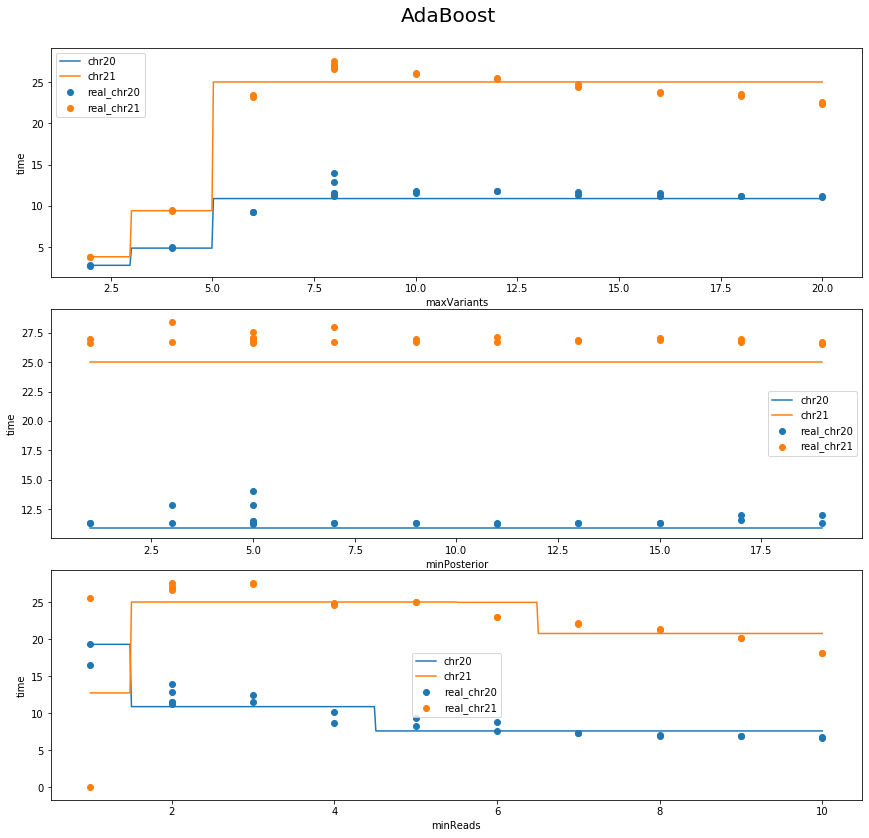

Current model: GBR


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index

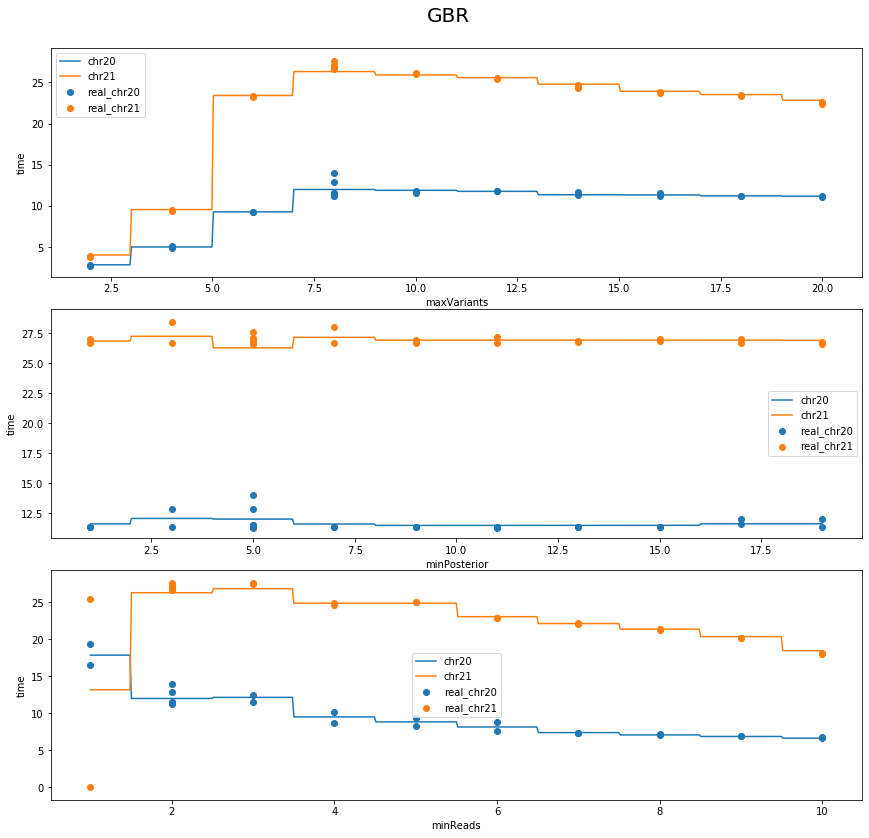

Current model: Random Forest


/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/chaofeng/anaconda3/envs/paropt/lib/python3.6/site-packages/ipykernel_laun

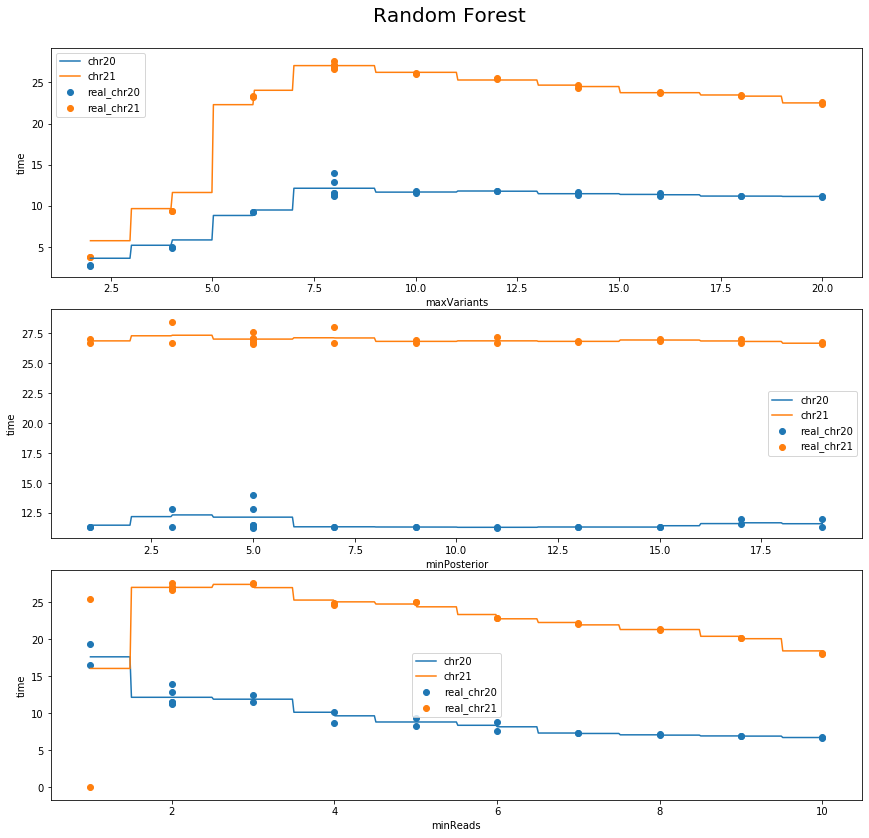

In [28]:
# evaluate plot time
evaluate_plot(chr21_df, defaults, 'time')